# script to capture images in a loop. 

## make sure, in the web interface, you close the camera. Run the cells one by one.

In [101]:
#some imports
import time
from PIL import Image
import numpy as np
import pandas as pd
import pathlib
from picamera2 import Picamera2, Preview
import pprint
from ipywidgets import interact, interactive
from IPython.display import display

In [102]:
amount = 10 #numbers of pictures to capture per setting
gains = [1]
exposures_us = [100,200,300] #np.arange(1000, 10000, 500, dtype=int) #start, stop, step - this must be an array type. can also be, [100,200,300,400] etc..
min_exposure = 100
#select mode a few cells below.
TIFF = True
UPLOAD_FOLDER = pathlib.Path("./images")
UPLOAD_FOLDER.mkdir(parents=False, exist_ok=True)

temp_save_dir = UPLOAD_FOLDER
final_save_dir = UPLOAD_FOLDER

In [103]:
#view camera model
Picamera2.global_camera_info()  #before init ;


[2:52:00.078747143] [12651]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2023-10-21T22:05:29+02:00)
[2:52:00.086685388] [13986]  WARN CameraSensorProperties camera_sensor_properties.cpp:333 No static properties available for 'mira016'
[2:52:00.086763239] [13986]  WARN CameraSensorProperties camera_sensor_properties.cpp:335 Please consider updating the camera sensor properties database
[2:52:00.106013133] [13986]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[2:52:00.108378570] [13986]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira016@36 to Unicam device /dev/media4 and ISP device /dev/media2


[{'Model': 'mira016',
  'Location': 2,
  'Rotation': 0,
  'Id': '/base/soc/i2c0mux/i2c@1/mira016@36'}]

In [104]:
#print all sensor modes
with Picamera2() as picam2:
    modes = picam2.sensor_modes
    pprint.pprint(picam2.sensor_modes)

[2:52:03.956652007] [12651]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2023-10-21T22:05:29+02:00)
[2:52:03.960205911] [13991]  WARN CameraSensorProperties camera_sensor_properties.cpp:333 No static properties available for 'mira016'
[2:52:03.960251559] [13991]  WARN CameraSensorProperties camera_sensor_properties.cpp:335 Please consider updating the camera sensor properties database
[2:52:03.968320431] [13991]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[2:52:03.969302309] [13991]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira016@36 to Unicam device /dev/media4 and ISP device /dev/media2
[2:52:03.978881998] [12651]  INFO Camera camera.cpp:1028 configuring streams: (0) 640x480-XBGR8888 (1) 400x400-SGRBG10_CSI2P
[2:52:03.979226901] [13991]  INFO RPI raspberrypi.cpp:851 Sensor: /base/soc/i2c0mux/i2c@1/mira016@36 - Selected sensor format: 400x400-SGRBG10_1X10 - Selected unicam form

[{'bit_depth': 10,
  'crop_limits': (0, 0, 400, 400),
  'exposure_limits': (74, 1600421, None),
  'format': SGRBG10_CSI2P,
  'fps': 100.0,
  'size': (400, 400),
  'unpacked': 'SGRBG10'},
 {'bit_depth': 12,
  'crop_limits': (0, 0, 400, 400),
  'exposure_limits': (74, 1600421, None),
  'format': SGRBG12_CSI2P,
  'fps': 100.0,
  'size': (400, 400),
  'unpacked': 'SGRBG12'},
 {'bit_depth': 8,
  'crop_limits': (0, 0, 400, 400),
  'exposure_limits': (74, 1600421, None),
  'format': SGRBG8,
  'fps': 100.0,
  'size': (400, 400),
  'unpacked': 'SGRBG8'}]


## select mode here

In [106]:
def f(mode):
    display(mode)
    return mode
w = interactive(f, mode=modes)
display(w)


interactive(children=(Dropdown(description='mode', options=({'format': SGRBG10_CSI2P, 'unpacked': 'SGRBG10', '…

# TURN OFF THE LIGHT

In [107]:
#DARK CONDITIONS
selected_mode = (w.result)
bit_mode = selected_mode["bit_depth"]
im_data = pd.DataFrame()
print(f'you have chosen mode {selected_mode}')

with Picamera2() as picam2:
    preview_config = picam2.create_preview_configuration(main={"size": selected_mode["size"]},
        raw={"format": selected_mode["unpacked"],
            "size": selected_mode["size"],
        })
    picam2.configure(preview_config)

    picam2.start()

    for analog_gain in gains:
        for exposure in [min_exposure]:
            print(f'DARK IMAGE - exposure in loop is {exposure}, gain in loop is {gain}')
        
            picam2.set_controls({"ExposureTime": exposure , "AnalogueGain": analog_gain})
            
            time.sleep(2)
            #raw = picam2.capture_buffer()
            #np.from_buffer
            
            size = selected_mode["size"]
        
            width = size[0]
            height = size[1]
            im_stack = []
            for i in range(amount):
                if bit_mode == 8:
                    image = picam2.capture_array("raw").view(np.uint8)
                else:
                    image = picam2.capture_array("raw").view(np.uint16)
                im_stack.append(image[0:height, 0:width])
                if TIFF:
                    # save images    
                    pilim = Image.fromarray(image)
                    filename = str(f"{UPLOAD_FOLDER}/img_exposure{exposure}_gain{analog_gain}_DARK_{i}.tiff")
                    pilim.save(filename)
                
            # get & save images
            name = f'bm={bit_mode}_ag={analog_gain}_fc={amount}_exp={round(exposure, 1)}_dark.npz'
            temp_im_dir = UPLOAD_FOLDER
            temp_im_path = pathlib.Path(temp_im_dir / name)
            np.savez(str(temp_im_path), im_stack)

            # add to image data
            temp = {'Analog Gain': [analog_gain],
                    'Bit Mode': [bit_mode],
                    'Exposure [ms]': [exposure],
                    'Frame Count': [amount],
                    'Power [uW/cm^2]': ['dark'],
                    'Exposure [uW/cm^2*s]': [0],
                    'Image Path_npz': [str(pathlib.Path(temp_im_dir / name))]}
            
            temp = pd.DataFrame.from_dict(temp)

            # concat raw to im_data
            im_data = pd.concat([im_data, temp], ignore_index=True).reset_index(drop=True)
    

you have chosen mode {'format': SGRBG10_CSI2P, 'unpacked': 'SGRBG10', 'bit_depth': 10, 'size': (400, 400), 'fps': 100.0, 'crop_limits': (0, 0, 400, 400), 'exposure_limits': (74, 1600421, None)}


[2:52:28.172188646] [12651]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2023-10-21T22:05:29+02:00)
[2:52:28.179258604] [13997]  WARN CameraSensorProperties camera_sensor_properties.cpp:333 No static properties available for 'mira016'
[2:52:28.179329473] [13997]  WARN CameraSensorProperties camera_sensor_properties.cpp:335 Please consider updating the camera sensor properties database
[2:52:28.195603421] [13997]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[2:52:28.197577973] [13997]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira016@36 to Unicam device /dev/media4 and ISP device /dev/media2
[2:52:28.208668811] [12651]  INFO Camera camera.cpp:1028 configuring streams: (0) 400x400-XBGR8888 (1) 400x400-SGRBG10
[2:52:28.209258379] [13997]  INFO RPI raspberrypi.cpp:851 Sensor: /base/soc/i2c0mux/i2c@1/mira016@36 - Selected sensor format: 400x400-SGRBG10_1X10 - Selected unicam format: 40

DARK IMAGE - exposure in loop is 100, gain in loop is 1


# TURN ON THE LIGHT

[2:52:33.012320911] [12651]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2023-10-21T22:05:29+02:00)
[2:52:33.015844613] [14004]  WARN CameraSensorProperties camera_sensor_properties.cpp:333 No static properties available for 'mira016'
[2:52:33.015880279] [14004]  WARN CameraSensorProperties camera_sensor_properties.cpp:335 Please consider updating the camera sensor properties database
[2:52:33.023800616] [14004]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[2:52:33.024864512] [14004]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira016@36 to Unicam device /dev/media4 and ISP device /dev/media2
[2:52:33.031341680] [12651]  INFO Camera camera.cpp:1028 configuring streams: (0) 400x400-XBGR8888 (1) 400x400-SGRBG10
[2:52:33.031699028] [14004]  INFO RPI raspberrypi.cpp:851 Sensor: /base/soc/i2c0mux/i2c@1/mira016@36 - Selected sensor format: 400x400-SGRBG10_1X10 - Selected unicam format: 40

exposure in loop is 100, gain in loop is 1
exposure in loop is 200, gain in loop is 1
exposure in loop is 300, gain in loop is 1


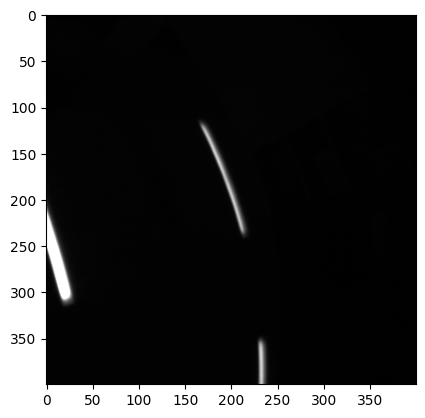

In [108]:
#ILLUMINATED CONDITIONS
with Picamera2() as picam2:
    preview_config = picam2.create_preview_configuration(main={"size": selected_mode["size"]},
        raw={"format": selected_mode["unpacked"],
            "size": selected_mode["size"],
        })
    picam2.configure(preview_config)

    picam2.start()   
    for analog_gain in gains:
        for exposure in exposures_us:
            print(f'exposure in loop is {exposure}, gain in loop is {gain}')
        
            picam2.set_controls({"ExposureTime": exposure , "AnalogueGain": analog_gain})
            
            time.sleep(2)
            #raw = picam2.capture_buffer()
            #np.from_buffer
            
            size = selected_mode["size"]
        
            width = size[0]
            height = size[1]
            im_stack = []
            for i in range(amount):
                if bit_mode == 8:
                    image = picam2.capture_array("raw").view(np.uint8)
                else:
                    image = picam2.capture_array("raw").view(np.uint16)
                im_stack.append(image[0:height, 0:width])
                if TIFF:
                    # save images    
                    pilim = Image.fromarray(image)
                    filename = str(f"{UPLOAD_FOLDER}/imgraw{i}_exposure{exposure}_gain{analog_gain}.tiff")
                    pilim.save(filename)
                
            # get & save images
            name = f'bm={bit_mode}_ag={analog_gain}_fc={amount}_exp={round(exposure, 1)}.npz'
            temp_im_dir = UPLOAD_FOLDER
            temp_im_path = pathlib.Path(temp_im_dir / name)
            np.savez(str(temp_im_path), im_stack)

            # add to image data
            temp = {'Analog Gain': [analog_gain],
                    'Bit Mode': [bit_mode],
                    'Exposure [ms]': [exposure],
                    'Frame Count': [amount],
                    'Power [uW/cm^2]': ['illuminated'],
                    'Exposure [uW/cm^2*s]': [0],
                    'Image Path_npz': [str(pathlib.Path(temp_im_dir / name))]}
            
            temp = pd.DataFrame.from_dict(temp)

            # concat raw to im_data
            im_data = pd.concat([im_data, temp], ignore_index=True).reset_index(drop=True)
            im_data_path = pathlib.Path(temp_save_dir / r'image_data.csv')
            im_data.to_csv(im_data_path, index=False)



    
            
    import matplotlib.pyplot as plt
    plt.imshow(imgs[0],cmap='gray')
    plt.show()